# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import time
sys.path.insert(0, "../")
import os
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from src_code.task_utils.config_parser import ConfigParser
from src_code.data_utils.dataset_utils import CaptchaDataset, get_dataloader
from src_code.data_utils.preprocessing import get_img_transform, get_rectangle_img_transform
from src_code.model_utils.mnist_ssd import SSD, BaseConv, pretty_print_module_list, AuxConv
import src_code.model_utils.utils_mnist_ssd as utils_mnist_ssd
from src_code.model_utils.mnist_ssd import SSD
from torch import nn
import yaml
from torchvision.utils import draw_bounding_boxes
from src_code.task_utils.evaluation import edit_score
import json
import os


# Load Config Files

In [2]:
# Load the base config
base_config_path = "../configs/configs_common_notebook.yaml"
if not Path(base_config_path).exists():
    raise FileNotFoundError(f"Base config file not found: {base_config_path}")

with open(base_config_path, "r") as file:
    base_config_dict = yaml.safe_load(file)

configs = ConfigParser(base_config_dict).get_parser()

# Load the SSD-specific config
ssd_config_path = "../configs/default_ssd_configs.yaml"
if not Path(ssd_config_path).exists():
    raise FileNotFoundError(f"SSD config file not found: {ssd_config_path}")

with open(ssd_config_path, "r") as file:
    ssd_config_dict = yaml.safe_load(file)

configs.update(ssd_config_dict)

config = {'task': 'train', 'data_configs': {'train_path': 'datasets/utn_dataset_curated/part2/train', 'val_path': 'datasets/utn_dataset_curated/part2/val', 'test_path': 'datasets/utn_dataset_curated/part2/test', 'preprocessing_related': {'color': False, 'mean': 0.5, 'std': 0.5, 'downscale_factor': 4}, 'dataset_related': {'train_preprocessed_dir': '../datasets/utn_dataset/part2/train/images', 'val_preprocessed_dir': '../datasets/utn_dataset/part2/val/images', 'test_preprocessed_dir': '../datasets/utn_dataset/part2/test/images', 'train_labels_dir': '../datasets/utn_dataset/part2/train/labels', 'val_labels_dir': '../datasets/utn_dataset/part2/val/labels', 'augment': True, 'shuffle': False}, 'augmentation_related': {'flip_prob': 0.5, 'zoom_prob': 0.3, 'rotation_prob': 0.2, 'line_prob': 0.1, 'salt_pepper_prob': 0.2}}, 'model_configs': {'name': 'ssd_mnist', 'resume_from_checkpoint_path': None, 'log_gradients': False, 'checkpoint': None, 'print_freq': 500, 'epochs': 10, 'batch_size': 100, 'de

# Load all required dataloaders

In [3]:
train_dataset = CaptchaDataset(
    configs.train_preprocessed_dir,
    labels_dir=configs.train_labels_dir,
    augment=False,
    config=configs,
    img_transform=get_rectangle_img_transform(configs)
)


val_dataset = CaptchaDataset(
    configs.val_preprocessed_dir,
    labels_dir=configs.val_labels_dir,
    augment=False,
    config=configs,
    img_transform=get_rectangle_img_transform(configs)
)

part2_test_dataset = CaptchaDataset(
    '../datasets/utn_dataset/part2/test/images',
    labels_dir=None,
    augment=False,
    config=configs,
    img_transform=get_rectangle_img_transform(configs)
)
part3_test_dataset = CaptchaDataset(
    '../datasets/utn_dataset/part3/test/images',
    labels_dir=None,
    augment=False,
    config=configs,
    img_transform=get_rectangle_img_transform(configs)
)
part4_test_dataset = CaptchaDataset(
    '../datasets/utn_dataset/part4/test/images',
    labels_dir=None,
    augment=False,
    config=configs,
    img_transform=get_rectangle_img_transform(configs)
)

train_loader = get_dataloader(train_dataset, configs)
val_loader = get_dataloader(val_dataset, configs)
part2_test_loader = get_dataloader(part2_test_dataset, configs)
part3_test_loader = get_dataloader(part3_test_dataset, configs)
part4_test_loader = get_dataloader(part4_test_dataset, configs)

print('train: ', len(train_loader.dataset))
print('val: ', len(val_loader.dataset))
print('part2: ', len(part2_test_loader.dataset))
print('part3: ', len(part3_test_loader.dataset))
print('part4: ', len(part4_test_loader.dataset))

train:  60000
val:  20000
part2:  20000
part3:  20000
part4:  20000


# Load Model and checkpoint

In [4]:
checkpoint_path = "../docs_and_results/demo/model_checkpoint_20.pth"

In [5]:
base_conv = BaseConv(configs.base_conv_conv_layers, 
                    configs.base_conv_input_size, chosen_fm=[-2, -1],
                    norm=nn.BatchNorm2d, act_fn=nn.ReLU(), spectral=False).to(configs.device)

In [6]:
new_h = configs.img_height // configs.downscale_factor
new_w = configs.img_width // configs.downscale_factor
setattr(configs, "base_conv_input_size", [new_h, new_w])
test_img = torch.zeros([1,1,configs.base_conv_input_size[0], configs.base_conv_input_size[1]]).to(configs.device)
base_size = pretty_print_module_list(base_conv.module_list, test_img)

aux_conv = AuxConv(configs.aux_conv_conv_layers, 
                configs.aux_conv_input_size, norm=nn.BatchNorm2d, act_fn=nn.ReLU(), spectral=False)
aux_size = pretty_print_module_list(aux_conv.module_list, torch.zeros(base_size[-1]))

setattr(configs, 'fm_channels', [base_size[i][1] for i in base_conv.fm_id] + [aux_size[i][1] for i in aux_conv.fm_id])
setattr(configs, 'fm_size', [base_size[i][-2:] for i in base_conv.fm_id] + [aux_size[i][-2:] for i in aux_conv.fm_id])
setattr(configs, 'n_fm', len(configs.fm_channels))
setattr(configs,'fm_prior_aspect_ratio', configs.fm_prior_aspect_ratio[:configs.n_fm])
setattr(configs,'fm_prior_scale', np.linspace(0.1, 0.9, configs.n_fm)) #[0.2, 0.375, 0.55, 0.725, 0.9] # [0.1, 0.2, 0.375, 0.55, 0.725, 0.9] 
assert len(configs.fm_prior_scale) == len(configs.fm_prior_aspect_ratio)
setattr(configs, 'n_prior_per_pixel', [len(i)+1 for i in configs.fm_prior_aspect_ratio]) #in fm1, each pixel has 4 priors
setattr(configs, 'multistep_milestones', list(range(10, configs.epochs, 5)))
utils_mnist_ssd.img_size = base_size[0][-1]

model = SSD(configs, base_conv, aux_conv).to(configs.device)

checkpoint = torch.load(checkpoint_path, weights_only=False, map_location=configs.device)
# Load model state
model.load_state_dict(checkpoint["model_state"])
model = model.to(configs.device)
model = model.eval()

There are 12780 priors in this model
Done initialization


# Generate final JSON predictions

In [7]:
# from src_code.task_utils.evaluation import test_generate_captchas_submission
# for item in ['part2', 'part3', 'part4']:
#     st_time = time.time()
#     test_generate_captchas_submission(model, part4_test_loader, configs, test_path = f"../datasets/utn_dataset/{item}/test/images", output_file = f"../docs_and_results/prediction_jsons/{item}.json")
#     et_time = time.time()
#     time_taken = et_time - st_time
#     print(f"{time_taken}sec taken for generating")

# Generate predicted bounding boxes

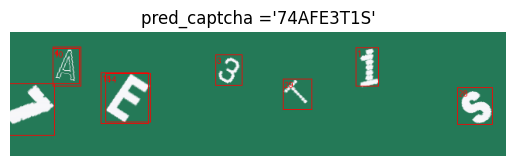

<Figure size 640x480 with 0 Axes>

In [17]:
# Sample image
import os
import torch
import json
from PIL import Image
from src_code.data_utils.preprocessing import get_rectangle_img_transform
import torchvision
import matplotlib.pyplot as plt
from src_code.task_utils.evaluation import plot_image_with_bboxes
# for i in range(20000):
#     tr:
image_id = "000053.png"
image = Image.open(f'../datasets/utn_dataset/part2/test/images/{image_id}').convert("RGB")
image_preprocessed = get_rectangle_img_transform(configs)(image)
image_torch = torchvision.transforms.functional.pil_to_tensor(image)
plt.imshow(image)
image_preprocessed = image_preprocessed.unsqueeze(0).to(configs.device)
# Model prediction
with torch.no_grad():
    loc_preds, cls_preds, _ = model(image_preprocessed)
    boxes, labels, scores = model.detect_object(loc_preds, cls_preds, min_score=0.3, max_overlap=0.5,top_k=20)
    plot_image_with_bboxes(image_id, configs, image, boxes[0], labels[0])

In [12]:
from src_code.task_utils.evaluation import generate_edit_distance

In [13]:
mean_edit_distance_train_loader, train_captcha_count = generate_edit_distance(model, train_loader, configs)
mean_edit_distance_val_loader, val_captcha_count = generate_edit_distance(model, val_loader, configs)

100%|█████████████████████████████████████████████████████████████| 200/200 [03:30<00:00,  1.05s/it]


In [14]:
print(f"{mean_edit_distance_val_loader = }")
print(f"{mean_edit_distance_train_loader = }")

mean_edit_distance_val_loader = 24.3633
mean_edit_distance_train_loader = 22.23675
